In [1]:
"""
Copyright (C) 2022 Dominik Lentrodt

This file is part of pyrot.

pyrot is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

pyrot is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with pyrot.  If not, see <http://www.gnu.org/licenses/>.
"""

%matplotlib inline

In [2]:
### analytic for 5-layer equal position GF for debugging ###

#define analytically derived 5-layer GF

def rij(betai, betaj):
    return (betai-betaj)/(betai+betaj)

def beta_j(kpar, k, n):
    return np.asarray([np.sqrt((k*i)**2-kpar**2) for i in n])

def r_total_5layers(theta, k, ns, ds, k0):
    # TODO
    return r_total_kp(theta, k, ns[2], ds[1], k0)

# def greenFct_s_VLM_kp(z, k, theta, n, d, k0):
#     rs01 = r_s_01_kp(theta, k, n, k0)
#     k_par = k0*np.cos(theta)
#     k_1 = n*k
#     beta_1 = np.sqrt(k_1**2 - k_par**2 + 0j)
#     return ((2j*np.pi/beta_1)*(1-np.exp(2j*beta_1*(d-z)))*(1-rs01*np.exp(2j*beta_1*z))
#            /(1-rs01*np.exp(2j*beta_1*d)))

def r_01_kp(theta, k, n, k0):
    k_par = k0*np.cos(theta)
    kz  = np.sqrt(      k**2 - k_par**2 + 0j)
    kz1 = np.sqrt( n**2*k**2 - k_par**2 + 0j)
    return ( kz - kz1 )/( kz + kz1 )

def r_total_kp(theta, k, n, d, k0):
    kappa     = k*d
    kappa_par = k0*d*np.cos(theta)
    r01 = r_01_kp(theta, k, n, k0)
    kappaz1 = np.sqrt( n**2*kappa**2 - kappa_par**2 )
    a = np.exp( 2j * kappaz1 )
    return (a-r01)/(r01*a-1)

def collLevShift5layers(theta, ω, gr, *args):
    return green_to_ClsSup_prefactor(ω, gr) * greenfunction5layers(theta, ω, *args)

def green_to_ClsSup_prefactor(ω, gr):
    dPol, rhoN, fLM = gr._dPol()
    k = ω*keV_to_inv_m
    k0 = eFe57.TransitionEnergy*keV_to_inv_m
    #dPol = dPol * np.sqrt(k0/k)**3 # note: this is commented, because we keep the dipole moment constant with energy
    d0_effs = (dPol * np.sqrt(rhoN*fLM*Layers[2].Thickness
                              *mFe57.Lattice[0].Element.Abundance))
    #omega_a = eFe57.TransitionEnergy # [keV] # note: NOT ω, since we only want to expand Green fn part.
    omega_a = ω
    gamma = mFe57.Lattice[0].Element.TransitionWidth * neV_to_keV * keV_to_inv_m 
    unit_factor = keV_to_inv_m**2/gamma /(4.*np.pi)
    prefactor = -omega_a**2 * unit_factor*d0_effs*d0_effs
    return prefactor/keV_to_inv_m

def greenfunction5layers(z, k, theta, ns, ds, k0): # k=[keV], ds=[1/keV]
    #bare quantities
    kpar = k0*np.cos(theta)
    betas = beta_j(kpar, k, ns)
    beta0, beta1, beta2, beta3, beta4, beta5, beta6 = betas
    r01, r12, r23, r34, r45, r56 = rij(betas[0:6], betas[1:7])
    _, d1, d2, d3, d4, d5, __ = ds
    phase_ = np.einsum('n,n...->n...', ds[1:6], betas[1:6])
    e1, e2, e3, e4, e5 = np.exp(2j*phase_)
    #effective quantities
    r20 = -(r12+r01*e1)/(1+r12*r01*e1)
    r30 = (-r23+r20*e2)/(1-r23*r20*e2)
    r46 = (r45+r56*e5)/(1+r45*r56*e5)
    r36 = (r34+r46*e4)/(1+r34*r46*e4)
    D = 1- r30*r36*e3
    return ((2j*np.pi/beta3)*(1/D)*(1+r36*np.exp(1j*beta3*d3))*
            (1+r30*np.exp(1j*beta3*d3)))

### Import packages

In [3]:
# for calculations
import numpy as np
import scipy as sp
from scipy.signal import argrelextrema

# for plotting
import matplotlib
import matplotlib.pylab as plt

In [4]:
### for development ###
import os
import sys
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pyrot

In [5]:
# ### if using installed distribution ###
# import pyrot

### Example system calculation

Define system

In [6]:
tThin = 0.01 #thin layer
N = [1.0,   4.0, 1.0,   4.0, 1.0] # Refractive index of each layer
T = [ -1, tThin, 1.0, tThin,  -1] # Thicknesses of each layer

omega = np.linspace(0.001, 15., 2000) # incident frequency / wavenumber

z0, z1 = [0.51, 0.51] # positions for Green's function evaluation

In [7]:
cavity = pyrot.Cavity1d(N, T)

Calculate empty cavity scattering

In [8]:
%%time
R_empty = cavity.reflection_intensity(omega)
T_empty = cavity.transmission_intensity(omega)

CPU times: user 2.16 ms, sys: 638 µs, total: 2.8 ms
Wall time: 2.31 ms


Calculate reflection minimum

In [9]:
max_inds = argrelextrema(R_empty, np.less)
ref_min = omega[max_inds[0][1]]+0.000001 # small number to avoid divide by zeroes
print(ref_min)

4.3528869429714865


Calculate **Green's function**

In [10]:
%%time
Green_function = cavity.green_function([z0], [z1], omega)[0,0,:]

CPU times: user 1.91 s, sys: 37.8 ms, total: 1.95 s
Wall time: 1.92 s


In [11]:
ns = [1.0,   4.0,    1.0, 1.0001,    1.0,   4.0, 1.0] # Refractive index of each layer
ds = [ -1, tThin, 1.0/3., 1.0/3., 1.0/3., tThin,  -1] # Thicknesses of each layer

Green_function_check = -greenfunction5layers(z0, omega, np.pi/2., ns, ds, omega)
print('Done!')

Done!


### Plot

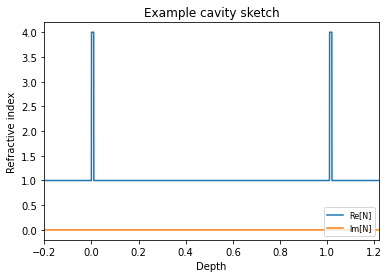

In [12]:
t_tot = np.sum(T[1:-1])
outside_buffer = 0.2
depth = np.linspace(-outside_buffer, t_tot+outside_buffer, 10000)

cavity.draw_cav(depth)

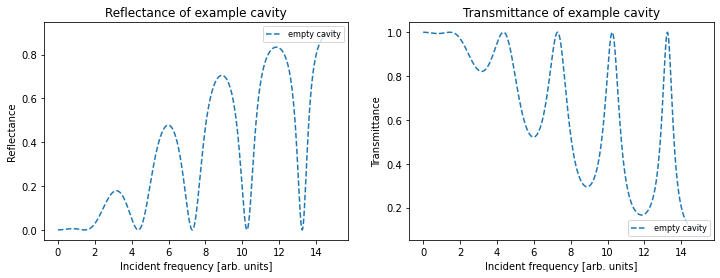

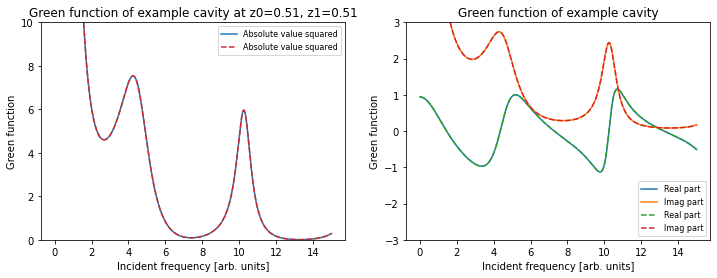

In [13]:
### reflection + Transmission ###
plt.figure(figsize=(6*2,4))

plt.subplot(121, xlabel='Incident frequency [arb. units]', ylabel='Reflectance',
            title='Reflectance of example cavity')
plt.plot(omega, R_empty, '--', label='empty cavity')
plt.legend(loc=1, fontsize=8)

plt.subplot(122, xlabel='Incident frequency [arb. units]', ylabel='Transmittance',
            title='Transmittance of example cavity')
plt.plot(omega, T_empty, '--', label='empty cavity')

plt.legend(loc=4, fontsize=8)

plt.show()

### Green's function ###
plt.figure(figsize=(6*2,4))

plt.subplot(121, xlabel='Incident frequency [arb. units]', ylabel='Green function',
            title='Green function of example cavity at z0={}, z1={}'.format(z0,z1))
plt.plot(omega, np.abs(Green_function)**2, '-', label='Absolute value squared')
plt.plot(omega, np.abs(Green_function_check)**2, 'C3--', label='Absolute value squared')

plt.legend(loc=1, fontsize=8)
plt.ylim([0,10])

plt.subplot(122, xlabel='Incident frequency [arb. units]', ylabel='Green function',
            title='Green function of example cavity')
plt.plot(omega, np.real(Green_function), '-', label='Real part')
plt.plot(omega, -np.imag(Green_function), '-', label='Imag part')
plt.plot(omega, np.real(Green_function_check), '--', label='Real part')
plt.plot(omega, -np.imag(Green_function_check), '--', label='Imag part')

plt.legend(loc=4, fontsize=8)
plt.ylim([-3,3])

plt.show()